In [1]:
%store -r g_two
%store -r g_one

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import scipy
from scipy.optimize import curve_fit
from scipy.stats import norm
import datetime as dt
import matplotlib.pyplot as plt

Riscrivo le released come mese per mese

In [59]:
released = g_one['Released'].map(dt.datetime.fromordinal).apply(lambda x: str(x.year)+'-'+str(x.month)).rename('date')
released = pd.to_datetime(released, format='%Y-%m')
released = released.to_frame()
released['map'] = released['date'].map(lambda x: 1)
released = released.groupby('date').count().reset_index()

In [60]:
released.drop(released.index[-8:], inplace=True)

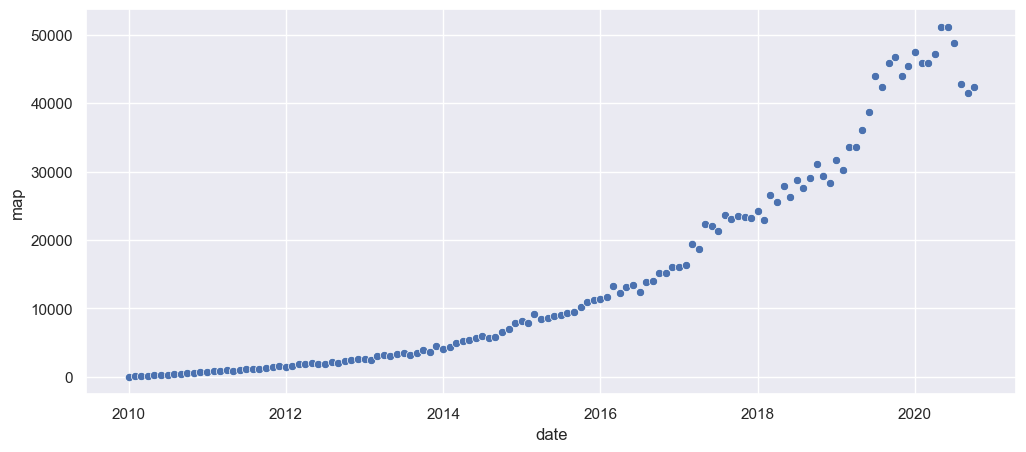

In [62]:
sns.set(style='darkgrid')
plt.figure(figsize = (12,5))
sns.scatterplot(x=released.date, y=released.map)
plt.show()

Regressione Polinomiale

In [95]:
x = np.arange(1, len(released)+1)
polynomial_features = PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(x.reshape(-1,1))

In [98]:
model = sm.OLS(released.map, xp)
model_fitted = model.fit()
ypred = model_fitted.predict(xp)
print(model_fitted.summary())
print(model_fitted.params)

                            OLS Regression Results                            
Dep. Variable:                    map   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     3330.
Date:                Thu, 12 Jan 2023   Prob (F-statistic):          1.89e-110
Time:                        18:28:08   Log-Likelihood:                -1177.5
No. Observations:                 130   AIC:                             2361.
Df Residuals:                     127   BIC:                             2370.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2241.5684    561.372      3.993      0.0

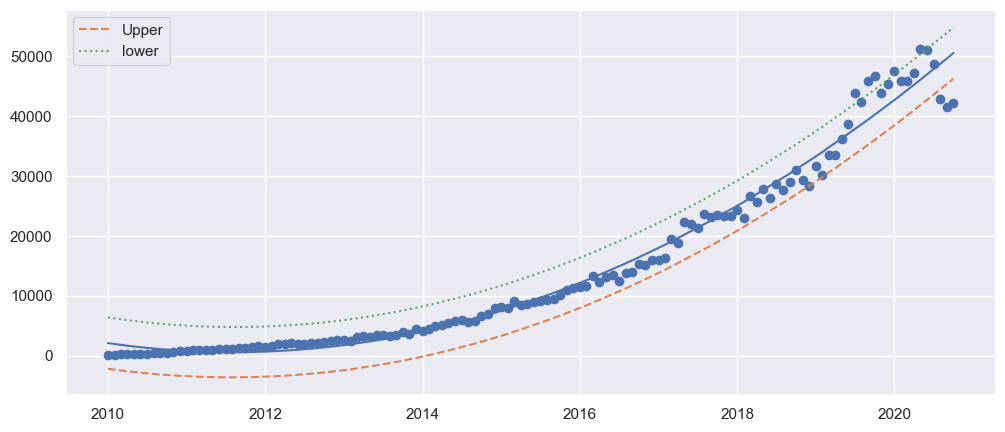

In [100]:
plt.figure(figsize = (12,5))
_, upper,lower = wls_prediction_std(model_fitted)
plt.scatter(x=released.date, y=released.map)
plt.plot(released.date,ypred)
plt.plot(released.date,upper,'--',label="Upper")
plt.plot(released.date,lower,':',label="lower")
plt.legend(loc='upper left')
plt.show()

In [101]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [102]:
print("Indice di correlazione e p-value : ", pearsonr(released.map.values, ypred))
print("R-Squared : ", r2_score(released.map.values, ypred))

Indice di correlazione e p-value :  PearsonRResult(statistic=0.9906005757436994, pvalue=1.8407244746104513e-112)
R-Squared :  0.9812895006637494


Regressione esponenziale

In [112]:
params, cov = scipy.optimize.curve_fit(lambda t, a,b,c : a*np.exp(b*t) + c, x, released.map.values, p0=(1,0.1,1))
params

array([ 3.66067395e+03,  2.12726549e-02, -4.99456791e+03])

In [171]:
def confidence_interval(cov: np.ndarray, params: np.ndarray, y_pred: np.ndarray, y_data: np.ndarray, alpha: float):
    n = len(y_data)
    p = len(params) 
    tval = norm.ppf(1.0 - alpha / 2.)
    residuals = abs(y_pred - y_data)
    sigma = np.sqrt(np.sum(residuals**2) / (n-p))
    conf_interval = tval * sigma
    lower = np.array(list(map(lambda x: x - conf_interval, y_pred)))
    upper = np.array(list(map(lambda x: x + conf_interval, y_pred)))
    return lower, upper


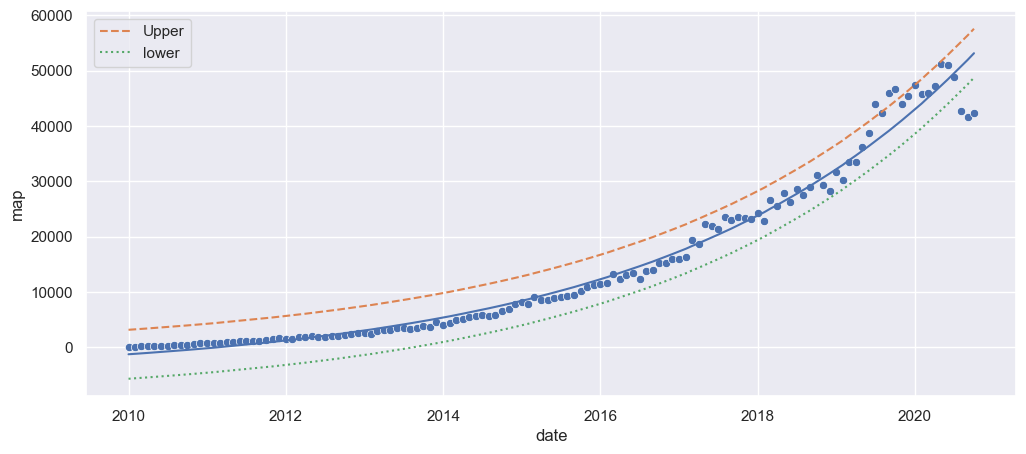

In [174]:
plt.figure(figsize = (12,5))
y_pred = np.array(list(map(lambda x: params[0]*np.exp(params[1]*x) + params[2], x)))
alpha=0.05
lower, upper = confidence_interval(cov=cov, params=params, y_pred=y_pred, y_data=released.map.values, alpha=alpha)
sns.scatterplot(x='date', y='map', data=released)
sns.lineplot(x=released.date, y = y_pred)
plt.plot(released.date, upper,'--',label="Upper")
plt.plot(released.date, lower,':',label="lower")
plt.legend(loc='upper left')
plt.show()

In [175]:
print("Indice di correlazione e p-value : ", pearsonr(released.map.values, y_pred))
print("R-Squared : ", r2_score(released.map.values, y_pred))

Indice di correlazione e p-value :  PearsonRResult(statistic=0.9891380958486327, pvalue=1.83947486771414e-108)
R-Squared :  0.9783941726590587


Il modello polinomiale è lievemente migliore del modello esponenziale, probabilmente a causa dei dati outlayer causati dalla pandemia del 2020